In [ ]:
  !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# 导入数据

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


这次我们准备使用五个监测站的数据。假定Bloomsbury监测站的数据出现异常，此时我们用Marylebone Road, Eltham, Harlington和N_Kensington的数据来推断Marylebone的数据。注意，该实验将会先从多变量预测开始预测，然后会从单变量开始预测

In [ ]:
Marylebone_Road=pd.read_csv('/content/drive/My Drive/air_inference/data/Marylebone_Road_clean.csv')
Bloomsbury=pd.read_csv('/content/drive/My Drive/air_inference/data/Bloomsbury_clean.csv')
Eltham=pd.read_csv('/content/drive/My Drive/air_inference/data/Eltham_clean.csv')
Harlington=pd.read_csv('/content/drive/My Drive/air_inference/data/Harlington_clean.csv')
N_Kensington=pd.read_csv('/content/drive/My Drive/air_inference/data/N_Kensington_clean.csv')

In [ ]:
Marylebone_Road=Marylebone_Road[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Bloomsbury=Bloomsbury[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Eltham=Eltham[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
Harlington=Harlington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]
N_Kensington=N_Kensington[['nox','no2','no','o3','pm2.5','ws','wd','air_temp']]

先将每个监测站的columns更名。加上后缀为监测站的首字母

In [ ]:
col_Marylebone=['nox_M','no2_M','no_M','o3_M','pm2.5_M','ws_M','wd_M','air_temp_M']
col_Bloomsbury=['nox_B','no2_B','no_B','o3_B','pm2.5_B','ws_B','wd_B','air_temp_B']
col_Eltham=['nox_E','no2_E','no_E','o3_E','pm2.5_E','ws_E','wd_E','air_temp_E']
col_Harlington=['nox_H','no2_H','no_H','o3_H','pm2.5_H','ws_H','wd_H','air_temp_H']
col_N_Kensington=['nox_N','no2_N','no_N','o3_N','pm2.5_N','ws_N','wd_N','air_temp_N']

Marylebone_Road.columns=col_Marylebone
Bloomsbury.columns=col_Bloomsbury
Eltham.columns=col_Eltham
Harlington.columns=col_Harlington
N_Kensington.columns=col_N_Kensington

接下来将所有监测站的数据拼接起来

In [ ]:
dataset=Bloomsbury.join(Marylebone_Road)
dataset=dataset.join(Eltham)
dataset=dataset.join(Harlington)
dataset=dataset.join(N_Kensington)
dataset.head()

,nox_B,no2_B,no_B,o3_B,pm2.5_B,ws_B,wd_B,air_temp_B,nox_M,no2_M,no_M,o3_M,pm2.5_M,ws_M,wd_M,air_temp_M,nox_E,no2_E,no_E,o3_E,pm2.5_E,ws_E,wd_E,air_temp_E,nox_H,no2_H,no_H,o3_H,pm2.5_H,ws_H,wd_H,air_temp_H,nox_N,no2_N,no_N,o3_N,pm2.5_N,ws_N,wd_N,air_temp_N
0,38.719371,27.599582,7.252141,47.360318,7.497625,4.598855,257.279906,5.378717,219.745313,81.948282,89.868883,20.680073,10.368619,4.594288,258.053368,5.187445,10.387007,7.380368,1.960881,59.104229,10.931926,4.508552,256.806923,5.348268,25.652376,17.162654,5.536853,58.319162,4.669857,6.536290,254.682024,4.977652,18.634584,16.685778,1.270981,60.070209,6.872474,4.594288,258.053368,5.187445
1,38.976582,27.836512,7.265368,47.042127,7.449653,4.603798,257.009139,5.412134,221.095446,81.975320,90.731783,20.623365,10.251473,4.602090,257.695571,5.219898,10.823717,7.652696,2.068089,58.843670,10.720061,4.498159,256.500375,5.379024,26.603729,17.836684,5.717718,57.659575,4.672704,6.554847,254.312810,5.012679,19.176644,17.122874,1.339436,59.637749,6.795094,4.602090,257.695571,5.219898
2,39.251382,28.072885,7.290429,46.715825,7.416401,4.621557,256.762603,5.453970,222.430163,82.046845,91.555615,20.582777,10.169084,4.613062,257.370167,5.255796,11.238689,7.897627,2.178986,58.579590,10.543322,4.510796,256.218836,5.420729,27.500740,18.461178,5.895449,57.038377,4.669182,6.579388,254.014423,5.051040,19.723134,17.548214,1.418449,59.211174,6.717488,4.613062,257.370167,5.255796
3,37.985254,27.997451,6.513879,46.400863,7.358787,4.636919,256.538550,5.502388,222.483880,81.654154,91.846755,20.745120,10.014187,4.630636,257.105888,5.300848,11.546266,8.070745,2.266678,58.360156,10.361331,4.524491,255.957051,5.467779,28.379700,19.068324,6.072721,56.435795,4.654887,6.636912,253.861244,5.099631,20.133219,17.844811,1.492463,58.913020,6.621239,4.630636,257.105888,5.300848
4,38.973919,28.512513,6.822754,46.033610,7.302818,4.658491,256.342472,5.554477,221.593263,81.130682,91.607309,20.959725,9.813301,4.661511,256.906359,5.350748,11.794165,8.191950,2.349305,58.183813,10.154809,4.533285,255.699470,5.517365,29.266844,19.683219,6.250279,55.827704,4.636542,6.716429,253.903225,5.156423,19.865833,17.747791,1.381354,58.671554,6.515320,4.661511,256.906359,5.350748


# 多站点多变量进行预测

In [ ]:
var=dataset.values

划分训练集，验证集和测试集

In [ ]:
def splitData(var,per_val,per_test):
    num_val=int(len(var)*per_val)
    num_test=int(len(var)*per_test)
    train_size=int(len(var)-num_val-num_test)
    train_data=var[0:train_size]
    val_data=var[train_size:train_size+num_val]
    test_data=var[train_size+num_val:train_size+num_val+num_test]
    return train_data,val_data,test_data

我们的验证集合测试集都取10%的时间

In [ ]:
train_data,val_data,test_data=splitData(var,0.1,0.1)

查看长度

In [ ]:
print('The length of train data, validation data and test data are:',len(train_data),',',len(val_data),',',len(test_data))

The length of train data, validation data and test data are: 14016 , 1752 , 1752



取一定大小的窗口进行滑动，每个窗口的label值是窗口下一个预测的第一个空气污染物的值

In [ ]:
train_window = 240
def create_train_sequence(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq.reshape(-1) ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_train_sequence(train_data, train_window)
print('The total number of train windows is',len(train_inout_seq))

The total number of train windows is 13776


与上面创建train_data的sequence不同，验证集数据(实验是1752个验证集数据)只是label。其数据部分还是需要借助于train集中的数据，大小为一个窗口。而这一个窗口的数据并不会在训练过程中被使用

In [ ]:
def create_val_sequence(train_data,val_data, tw):
    temp=np.vstack((train_data,val_data))   #先将训练集和测试集合并
    inout_seq = []
    L = len(val_data)
    for i in range(L):
        val_seq = temp[-(train_window+L)+i:-L+i]
        val_label = test_data[i:i+1]
        inout_seq.append((val_seq.reshape(-1) ,val_label))

    return inout_seq



In [ ]:
val_inout_seq = create_val_sequence(train_data, val_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


 此时的label的shape是[1,40]。注意，真正的label只有这40个值中的前五个

In [ ]:
def create_test_sequence(train_data,val_data,test_data, tw):
    temp=np.vstack((train_data,val_data))   #先将训练集和测试集合并
    temp=np.vstack((temp,test_data))
    inout_seq = []
    L = len(test_data)
    for i in range(L):
        test_seq = temp[-(train_window+L)+i:-L+i]
        test_label = test_data[i:i+1]
        inout_seq.append((test_seq.reshape(-1) ,test_label))

    return inout_seq

In [ ]:
test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)
print('The total number of validation windows is',len(val_inout_seq))

The total number of validation windows is 1752


In [ ]:
X_train=np.array([x[0] for x in train_inout_seq])
y_train=np.array([x[1] for x in train_inout_seq]).squeeze(1)

X_val=np.array([x[0] for x in val_inout_seq])
y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)

X_test=np.array([x[0] for x in test_inout_seq])
y_test=np.array([x[1] for x in test_inout_seq]).squeeze(1)


In [ ]:
X_train.shape

(13776, 9600)

下面是lightgbm的参数

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 29,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 6,
    'verbose': 0
}

下面的字典用于存放不同污染物的index

In [ ]:
index_dic={
    'nox':0,
    'no2':1,
    'no':2,
    'o3':3,
    'pm2.5':4    
}

In [ ]:
X_test[0].reshape(1,-1).shape

(1, 9600)

In [ ]:
import copy
def predict_lgb_mul(attr):
  lgb_train = lgb.Dataset(X_train,y_train[:,index_dic[attr]])
  lgb_val = lgb.Dataset(X_val, y_val[:,index_dic[attr]], reference=lgb_train)

  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=30,
                  valid_sets=lgb_val,
                  # early_stopping_rounds=5
                  )

  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

  x = np.arange(len(train_data)+len(val_data), len(dataset), 1)
  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):,attr+'_B'].values,color="red",label='real value')
  plt.plot(y_pred,label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)
  plt.show()


  print('mse:', mean_squared_error(y_test[:,index_dic[attr]], y_pred))
  print('mse:', mean_absolute_error(y_test[:,index_dic[attr]], y_pred))


  #预测24小时之后的情况
  fut_pred = 96
  pred_list=[]
  X_test_mask=copy.copy(X_test)

  for i in range(fut_pred):
    y_pred = gbm.predict(X_test_mask[i].reshape(1,-1), num_iteration=gbm.best_iteration)
    pred_list.append(y_pred)

    if(i!=fut_pred-1):
      X_test_mask[i+1,40*index_dic[attr]+39]=y_pred


  plt.figure(figsize=(8, 6))
  plt.grid(True)

  plt.plot(dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred,attr+'_B'].values,color="red",label='real value')
  plt.plot(pred_list,label='prediction')

  plt.title('hours vs '+attr)
  plt.ylabel(attr)
  plt.xlabel('hour')

  plt.legend(loc='upper right',fontsize=15)
  plt.show()

  y_true=dataset.loc[len(dataset)-len(test_data):len(dataset)-len(test_data)+fut_pred-1,attr+'_B'].values
  y_pred=pred_list

  print('mse: ',mean_squared_error(y_true, y_pred))
  print('mae: ',mean_absolute_error(y_true, y_pred))


  y_pred=pd.DataFrame(y_pred)
  y_true=pd.DataFrame(y_true)

  y_pred.to_csv('/content/drive/My Drive/air_inference/result24/lightGBM_'+attr+'.csv',index=False)
  y_true.to_csv('/content/drive/My Drive/air_inference/result24/true_'+attr+'.csv',index=False)









  # y_pred=pd.DataFrame(y_pred)
  # y_pred.to_csv("/content/drive/My Drive/air_inference/result/lgb_mul_"+attr+".csv",header = None, index = None)

对nox进行预测

[1]	valid_0's l2: 765.437	valid_0's l1: 21.3935
[2]	valid_0's l2: 781.691	valid_0's l1: 21.5957
[3]	valid_0's l2: 800.201	valid_0's l1: 21.8251
[4]	valid_0's l2: 820.597	valid_0's l1: 22.0738
[5]	valid_0's l2: 842.757	valid_0's l1: 22.3561
[6]	valid_0's l2: 866.043	valid_0's l1: 22.6466
[7]	valid_0's l2: 890.207	valid_0's l1: 22.952
[8]	valid_0's l2: 915.012	valid_0's l1: 23.2716
[9]	valid_0's l2: 940.047	valid_0's l1: 23.5925
[10]	valid_0's l2: 965.281	valid_0's l1: 23.9186
[11]	valid_0's l2: 991.006	valid_0's l1: 24.2493
[12]	valid_0's l2: 1016.43	valid_0's l1: 24.5878
[13]	valid_0's l2: 1041.74	valid_0's l1: 24.9248
[14]	valid_0's l2: 1066.77	valid_0's l1: 25.2615
[15]	valid_0's l2: 1091.4	valid_0's l1: 25.5947
[16]	valid_0's l2: 1116	valid_0's l1: 25.9225
[17]	valid_0's l2: 1139.8	valid_0's l1: 26.2407
[18]	valid_0's l2: 1163.32	valid_0's l1: 26.5522
[19]	valid_0's l2: 1186.11	valid_0's l1: 26.851
[20]	valid_0's l2: 1208.27	valid_0's l1: 27.1406
[21]	valid_0's l2: 1229.71	valid_0's

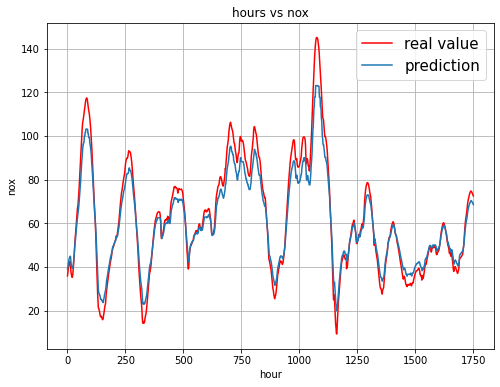

mse: 36.90717384972954
mse: 4.696129491745331


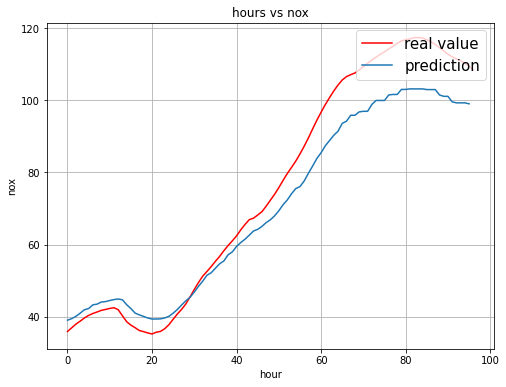

mse:  72.8189557305342
mae:  7.106195901923847
CPU times: user 3min 26s, sys: 2.66 s, total: 3min 28s
Wall time: 1min 50s


In [ ]:
%%time
predict_lgb_mul('nox')

对no2进行预测

[1]	valid_0's l2: 94.5502	valid_0's l1: 7.95348
[2]	valid_0's l2: 95.9417	valid_0's l1: 8.06096
[3]	valid_0's l2: 98.2457	valid_0's l1: 8.19412
[4]	valid_0's l2: 101.406	valid_0's l1: 8.34127
[5]	valid_0's l2: 105.223	valid_0's l1: 8.50081
[6]	valid_0's l2: 109.633	valid_0's l1: 8.6725
[7]	valid_0's l2: 114.489	valid_0's l1: 8.85473
[8]	valid_0's l2: 119.791	valid_0's l1: 9.04796
[9]	valid_0's l2: 125.385	valid_0's l1: 9.25109
[10]	valid_0's l2: 131.178	valid_0's l1: 9.45641
[11]	valid_0's l2: 137.106	valid_0's l1: 9.66588
[12]	valid_0's l2: 143.269	valid_0's l1: 9.88412
[13]	valid_0's l2: 149.498	valid_0's l1: 10.1015
[14]	valid_0's l2: 155.65	valid_0's l1: 10.3093
[15]	valid_0's l2: 161.862	valid_0's l1: 10.5133
[16]	valid_0's l2: 167.991	valid_0's l1: 10.7079
[17]	valid_0's l2: 174.094	valid_0's l1: 10.8962
[18]	valid_0's l2: 180.069	valid_0's l1: 11.078
[19]	valid_0's l2: 186.015	valid_0's l1: 11.2568
[20]	valid_0's l2: 191.833	valid_0's l1: 11.4299
[21]	valid_0's l2: 197.491	valid

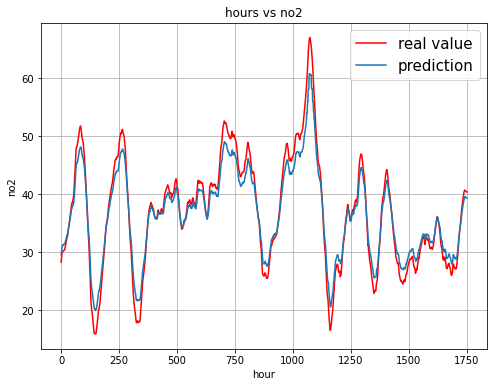

mse: 4.449792932092665
mse: 1.716132706159509


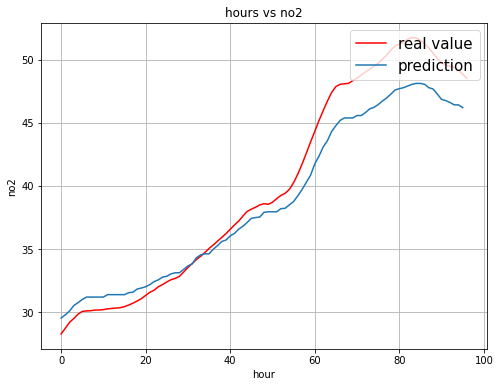

mse:  4.262120385153515
mae:  1.6918962583520545
CPU times: user 3min 31s, sys: 1.16 s, total: 3min 32s
Wall time: 1min 51s


In [ ]:
%%time
predict_lgb_mul('no2')

对no进行预测

[1]	valid_0's l2: 149.773	valid_0's l1: 9.12838
[2]	valid_0's l2: 152.76	valid_0's l1: 9.18742
[3]	valid_0's l2: 155.931	valid_0's l1: 9.26432
[4]	valid_0's l2: 159.107	valid_0's l1: 9.35118
[5]	valid_0's l2: 162.391	valid_0's l1: 9.44976
[6]	valid_0's l2: 165.755	valid_0's l1: 9.55113
[7]	valid_0's l2: 169.069	valid_0's l1: 9.65049
[8]	valid_0's l2: 172.426	valid_0's l1: 9.75168
[9]	valid_0's l2: 175.732	valid_0's l1: 9.8545
[10]	valid_0's l2: 179.027	valid_0's l1: 9.9545
[11]	valid_0's l2: 182.329	valid_0's l1: 10.0576
[12]	valid_0's l2: 185.531	valid_0's l1: 10.1582
[13]	valid_0's l2: 188.666	valid_0's l1: 10.2555
[14]	valid_0's l2: 191.744	valid_0's l1: 10.3522
[15]	valid_0's l2: 194.784	valid_0's l1: 10.4464
[16]	valid_0's l2: 197.74	valid_0's l1: 10.5379
[17]	valid_0's l2: 200.597	valid_0's l1: 10.627
[18]	valid_0's l2: 203.394	valid_0's l1: 10.7176
[19]	valid_0's l2: 206.091	valid_0's l1: 10.8034
[20]	valid_0's l2: 208.694	valid_0's l1: 10.8868
[21]	valid_0's l2: 211.214	valid_0

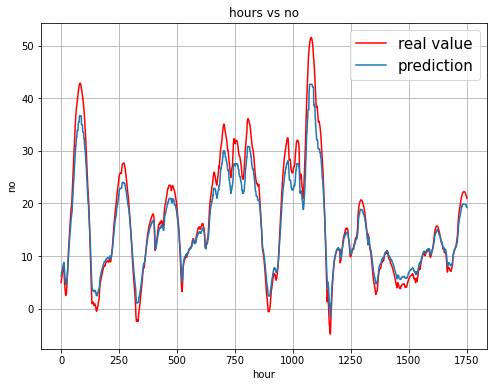

mse: 7.229939699409453
mse: 2.0186753038619525


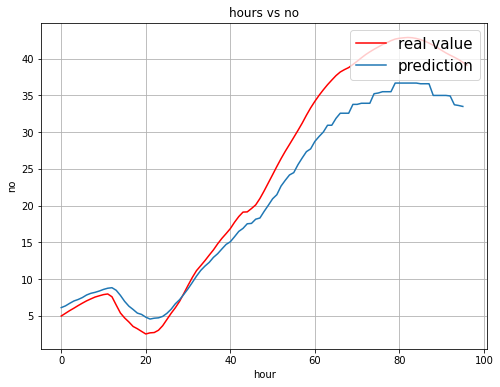

mse:  17.25327825763644
mae:  3.4620188341772433
CPU times: user 3min 19s, sys: 1.43 s, total: 3min 21s
Wall time: 1min 46s


In [ ]:
%%time
predict_lgb_mul('no')

对o3进行预测

[1]	valid_0's l2: 325.23	valid_0's l1: 15.4232
[2]	valid_0's l2: 328.54	valid_0's l1: 15.4967
[3]	valid_0's l2: 332.111	valid_0's l1: 15.5682
[4]	valid_0's l2: 336.088	valid_0's l1: 15.6531
[5]	valid_0's l2: 340.244	valid_0's l1: 15.7384
[6]	valid_0's l2: 344.582	valid_0's l1: 15.821
[7]	valid_0's l2: 349.05	valid_0's l1: 15.9017
[8]	valid_0's l2: 353.517	valid_0's l1: 15.9781
[9]	valid_0's l2: 358.177	valid_0's l1: 16.0566
[10]	valid_0's l2: 363.061	valid_0's l1: 16.1376
[11]	valid_0's l2: 367.814	valid_0's l1: 16.2152
[12]	valid_0's l2: 372.404	valid_0's l1: 16.2902
[13]	valid_0's l2: 376.901	valid_0's l1: 16.3624
[14]	valid_0's l2: 381.349	valid_0's l1: 16.4352
[15]	valid_0's l2: 385.712	valid_0's l1: 16.5077
[16]	valid_0's l2: 390.145	valid_0's l1: 16.5795
[17]	valid_0's l2: 394.613	valid_0's l1: 16.65
[18]	valid_0's l2: 398.721	valid_0's l1: 16.7143
[19]	valid_0's l2: 402.751	valid_0's l1: 16.7762
[20]	valid_0's l2: 406.638	valid_0's l1: 16.8357
[21]	valid_0's l2: 410.398	valid_0'

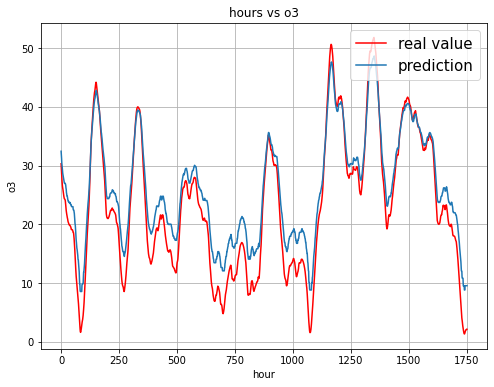

mse: 15.077673845198444
mse: 3.3208823081546757


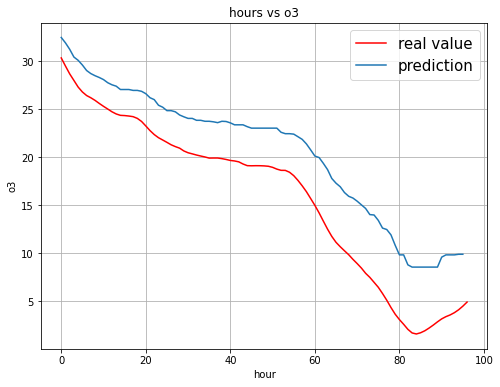

mse:  23.449165111593057
mae:  4.585610443888388
CPU times: user 3min 36s, sys: 1.06 s, total: 3min 37s
Wall time: 1min 53s


In [ ]:
%%time
predict_lgb_mul('o3')

对pm2.5进行预测

[1]	valid_0's l2: 25.6233	valid_0's l1: 4.29827
[2]	valid_0's l2: 25.4418	valid_0's l1: 4.28031
[3]	valid_0's l2: 25.4467	valid_0's l1: 4.27049
[4]	valid_0's l2: 25.6024	valid_0's l1: 4.26353
[5]	valid_0's l2: 25.8891	valid_0's l1: 4.26053
[6]	valid_0's l2: 26.2902	valid_0's l1: 4.2619
[7]	valid_0's l2: 26.7858	valid_0's l1: 4.26749
[8]	valid_0's l2: 27.3585	valid_0's l1: 4.27623
[9]	valid_0's l2: 27.9931	valid_0's l1: 4.28605
[10]	valid_0's l2: 28.6809	valid_0's l1: 4.29868
[11]	valid_0's l2: 29.413	valid_0's l1: 4.31297
[12]	valid_0's l2: 30.1744	valid_0's l1: 4.32802
[13]	valid_0's l2: 30.9627	valid_0's l1: 4.3448
[14]	valid_0's l2: 31.7671	valid_0's l1: 4.36212
[15]	valid_0's l2: 32.5767	valid_0's l1: 4.37912
[16]	valid_0's l2: 33.3877	valid_0's l1: 4.39714
[17]	valid_0's l2: 34.1989	valid_0's l1: 4.41533
[18]	valid_0's l2: 35.0198	valid_0's l1: 4.43867
[19]	valid_0's l2: 35.8225	valid_0's l1: 4.46503
[20]	valid_0's l2: 36.6311	valid_0's l1: 4.49561
[21]	valid_0's l2: 37.4121	valid

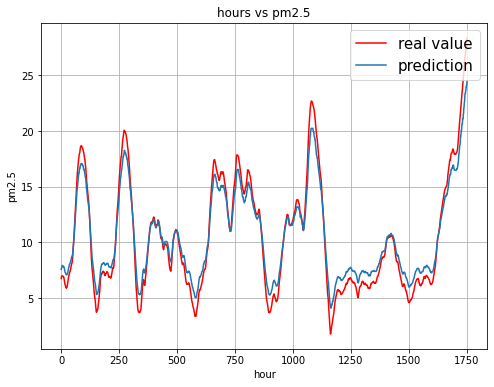

mse: 1.262498637757139
mse: 0.9504890060216384


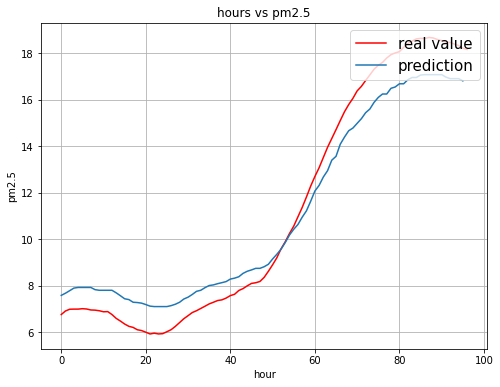

mse:  1.1371638773551067
mae:  0.9876775172277231
CPU times: user 3min 28s, sys: 1.01 s, total: 3min 29s
Wall time: 1min 51s


In [ ]:
%%time
predict_lgb_mul('pm2.5')

# 对单站点多变量进行预测

In [ ]:
#数据集
dataset=Bloomsbury.values

#划分数据集
train_data,val_data,test_data=splitData(dataset,0.1,0.1)

train_window=240
train_inout_seq = create_train_sequence(train_data, train_window)
val_inout_seq = create_val_sequence(train_data, val_data,train_window)
test_inout_seq = create_test_sequence(train_data, val_data, test_data,train_window)

def predict_lgb_sin(attr):

  X_train=np.array([x[0] for x in train_inout_seq])
  y_train=np.array([x[1] for x in train_inout_seq]).squeeze(1)

  X_val=np.array([x[0] for x in val_inout_seq])
  y_val=np.array([x[1] for x in val_inout_seq]).squeeze(1)

  X_test=np.array([x[0] for x in test_inout_seq])
  y_test=np.array([x[1] for x in test_inout_seq]).squeeze(1)

  lgb_train = lgb.Dataset(X_train,y_train[:,index_dic[attr]])
  lgb_val = lgb.Dataset(X_val, y_val[:,index_dic[attr]], reference=lgb_train)

  gbm = lgb.train(params,
                  lgb_train,
                  num_boost_round=30,
                  valid_sets=lgb_val,
                  # early_stopping_rounds=5
                  )

  y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

  print(y_pred.shape)

  print('mse:', mean_squared_error(y_test[:,index_dic[attr]], y_pred))
  print('mse:', mean_absolute_error(y_test[:,index_dic[attr]], y_pred))

  y_pred=pd.DataFrame(y_pred)
  y_pred.to_csv("/content/drive/My Drive/air_inference/result/lgb_single_"+attr+".csv",header = None, index = None)

对nox进行预测

In [ ]:
%%time
predict_lgb_sin('nox')

[1]	valid_0's l2: 765.537	valid_0's l1: 21.3929
[2]	valid_0's l2: 781.9	valid_0's l1: 21.5981
[3]	valid_0's l2: 800.347	valid_0's l1: 21.8255
[4]	valid_0's l2: 820.556	valid_0's l1: 22.0754
[5]	valid_0's l2: 842.574	valid_0's l1: 22.3499
[6]	valid_0's l2: 865.947	valid_0's l1: 22.6455
[7]	valid_0's l2: 890.181	valid_0's l1: 22.9497
[8]	valid_0's l2: 914.778	valid_0's l1: 23.2649
[9]	valid_0's l2: 939.863	valid_0's l1: 23.5923
[10]	valid_0's l2: 965.485	valid_0's l1: 23.9194
[11]	valid_0's l2: 990.813	valid_0's l1: 24.2492
[12]	valid_0's l2: 1016.27	valid_0's l1: 24.5878
[13]	valid_0's l2: 1041.54	valid_0's l1: 24.9235
[14]	valid_0's l2: 1066.93	valid_0's l1: 25.2623
[15]	valid_0's l2: 1091.98	valid_0's l1: 25.5996
[16]	valid_0's l2: 1116.63	valid_0's l1: 25.9289
[17]	valid_0's l2: 1140.5	valid_0's l1: 26.2479
[18]	valid_0's l2: 1163.83	valid_0's l1: 26.5575
[19]	valid_0's l2: 1186.65	valid_0's l1: 26.8582
[20]	valid_0's l2: 1208.7	valid_0's l1: 27.1448
[21]	valid_0's l2: 1230.23	valid_

对no2进行预测

In [ ]:
%%time
predict_lgb_sin('no2')

[1]	valid_0's l2: 94.5502	valid_0's l1: 7.95348
[2]	valid_0's l2: 95.9417	valid_0's l1: 8.06096
[3]	valid_0's l2: 98.2457	valid_0's l1: 8.19412
[4]	valid_0's l2: 101.406	valid_0's l1: 8.34127
[5]	valid_0's l2: 105.223	valid_0's l1: 8.50081
[6]	valid_0's l2: 109.633	valid_0's l1: 8.6725
[7]	valid_0's l2: 114.551	valid_0's l1: 8.85635
[8]	valid_0's l2: 119.795	valid_0's l1: 9.04979
[9]	valid_0's l2: 125.378	valid_0's l1: 9.25096
[10]	valid_0's l2: 131.172	valid_0's l1: 9.45585
[11]	valid_0's l2: 137.146	valid_0's l1: 9.66755
[12]	valid_0's l2: 143.235	valid_0's l1: 9.88406
[13]	valid_0's l2: 149.394	valid_0's l1: 10.0993
[14]	valid_0's l2: 155.607	valid_0's l1: 10.3083
[15]	valid_0's l2: 161.819	valid_0's l1: 10.5125
[16]	valid_0's l2: 167.941	valid_0's l1: 10.7072
[17]	valid_0's l2: 174	valid_0's l1: 10.8954
[18]	valid_0's l2: 180.033	valid_0's l1: 11.0794
[19]	valid_0's l2: 185.969	valid_0's l1: 11.2585
[20]	valid_0's l2: 191.752	valid_0's l1: 11.4319
[21]	valid_0's l2: 197.44	valid_0'

对no进行预测

In [ ]:
%%time
predict_lgb_sin('no')

[1]	valid_0's l2: 149.773	valid_0's l1: 9.12838
[2]	valid_0's l2: 152.76	valid_0's l1: 9.18742
[3]	valid_0's l2: 155.931	valid_0's l1: 9.26432
[4]	valid_0's l2: 159.107	valid_0's l1: 9.35118
[5]	valid_0's l2: 162.439	valid_0's l1: 9.45033
[6]	valid_0's l2: 165.787	valid_0's l1: 9.55035
[7]	valid_0's l2: 169.161	valid_0's l1: 9.65055
[8]	valid_0's l2: 172.485	valid_0's l1: 9.75302
[9]	valid_0's l2: 175.884	valid_0's l1: 9.8577
[10]	valid_0's l2: 179.188	valid_0's l1: 9.95969
[11]	valid_0's l2: 182.482	valid_0's l1: 10.0633
[12]	valid_0's l2: 185.681	valid_0's l1: 10.1636
[13]	valid_0's l2: 188.837	valid_0's l1: 10.2628
[14]	valid_0's l2: 191.914	valid_0's l1: 10.3595
[15]	valid_0's l2: 194.94	valid_0's l1: 10.4535
[16]	valid_0's l2: 197.885	valid_0's l1: 10.5449
[17]	valid_0's l2: 200.747	valid_0's l1: 10.6336
[18]	valid_0's l2: 203.535	valid_0's l1: 10.7217
[19]	valid_0's l2: 206.179	valid_0's l1: 10.8057
[20]	valid_0's l2: 208.777	valid_0's l1: 10.8894
[21]	valid_0's l2: 211.29	valid_

对o3进行预测

In [ ]:
%%time
predict_lgb_sin('o3')

[1]	valid_0's l2: 325.23	valid_0's l1: 15.4232
[2]	valid_0's l2: 328.54	valid_0's l1: 15.4967
[3]	valid_0's l2: 332.138	valid_0's l1: 15.5693
[4]	valid_0's l2: 336	valid_0's l1: 15.651
[5]	valid_0's l2: 340.18	valid_0's l1: 15.7368
[6]	valid_0's l2: 344.425	valid_0's l1: 15.8181
[7]	valid_0's l2: 348.889	valid_0's l1: 15.899
[8]	valid_0's l2: 353.394	valid_0's l1: 15.9773
[9]	valid_0's l2: 358.001	valid_0's l1: 16.0543
[10]	valid_0's l2: 362.586	valid_0's l1: 16.1305
[11]	valid_0's l2: 367.211	valid_0's l1: 16.2067
[12]	valid_0's l2: 371.739	valid_0's l1: 16.2802
[13]	valid_0's l2: 376.222	valid_0's l1: 16.3536
[14]	valid_0's l2: 380.646	valid_0's l1: 16.4266
[15]	valid_0's l2: 385.014	valid_0's l1: 16.4991
[16]	valid_0's l2: 389.34	valid_0's l1: 16.5695
[17]	valid_0's l2: 393.553	valid_0's l1: 16.638
[18]	valid_0's l2: 397.613	valid_0's l1: 16.702
[19]	valid_0's l2: 401.569	valid_0's l1: 16.7633
[20]	valid_0's l2: 405.469	valid_0's l1: 16.8233
[21]	valid_0's l2: 409.236	valid_0's l1: 

对pm2.5进行预测

In [ ]:
predict_lgb_sin('pm2.5')